# Linear SVM
As part of the overall stacking model, I will develop three linear models: Logistic Regression, Ridge Classifier, and Linear SVM. 
  
In this notebook, I set out to optimise the Linear SVM model. The optimisation sequence was as follows:  
  
1. C (0.05)
2. RFECV (33)
3. Cost (L2)
4. Loss (Squared Hinge)
5. C (0.035)
  
The final CV score was **83.05%**.

In [1]:
# Import modules
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.feature_selection import RFECV, RFE
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, auc, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
from sklearn.svm import LinearSVC
import kaggle_titanic as kt
import warnings

# Settings
%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

## Prepare Data

In [2]:
# Import data
df = pd.read_csv('train.csv')

# Clean data
df = kt.clean_all(df)

# Encode data (only for RFECV purposes)
df_encoded, _ = kt.encode_train(df)

## Global Settings

In [3]:
# Create fold indices
folds = kt.get_folds(df=df, random_state=123)

# Get all datasets
all_sets = kt.prep_sets(df, folds)

## Iteration 1: Tune Alpha

Computing test scores for C = 0.0001...Done!
Computing test scores for C = 0.001...Done!
Computing test scores for C = 0.01...Done!
Computing test scores for C = 0.05...Done!
Computing test scores for C = 0.1...Done!
Computing test scores for C = 0.5...Done!
Computing test scores for C = 1...Done!
Computing test scores for C = 5...Done!
Computing test scores for C = 10...Done!
Computing test scores for C = 20...Done!
Computing test scores for C = 50...Done!


[ RESULTS ]
   Best Score: 0.8293821483679441
Optimal Value: 0.05


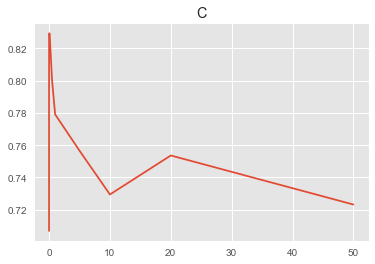

In [5]:
# Define parameters
param_c = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
params = {
    'C': param_c
}

# Grid Search with CV
cv_res, best_c = kt.score_grid(
    estimator = LinearSVC(
        random_state = 123,
        penalty = 'l2',
        loss = 'squared_hinge'
        # C = best_c
    ),  
    params = params,
    all_sets = all_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 2: RFECV for Feature Selection

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:   16.3s finished


   Best Score: 0.8338778851026691
Optimal Value: 33


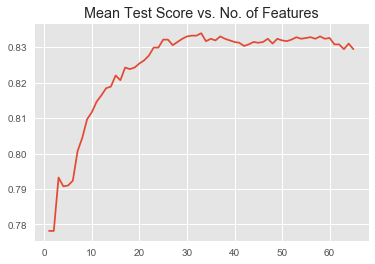

In [7]:
# Run RFECV
cv_res, best_n_features, opt_feats = kt.custom_rfecv(
    estimator = LinearSVC(
        random_state = 123,
        penalty = 'l2',
        loss = 'squared_hinge',
        C = best_c
    ),
    sub_sets = all_sets,
    df = df_encoded,
    step = 1,
    n_jobs = 3,
    verbose = True
)

### Subset Features

In [8]:
# Separate features
final_feats = list(opt_feats)
print(final_feats)

['pclass_OC', 'sex_BN', 'sibsp_NM', 'sibsp_OC', 'parch_NM', 'parch_OC', 'title_ME', 'age_ME', 'cabno_ME', 'pclass_OH_CLASS2', 'title_OH_Master.', 'title_OH_Miss.', 'title_OH_Mr.', 'title_OH_Mrs.', 'title_OH_Other', 'sex_OH_female', 'sex_OH_male', 'age_OH_A0', 'age_OH_A6', 'age_OH_A8', 'age_OH_A9', 'parch_OH_Two or More', 'ticlen_OH_L6', 'ticlen_OH_LO', 'fare_OH_G1', 'fare_OH_G2', 'fare_OH_G5', 'cabletter_OH_B/D/E', 'cabletter_OH_Others', 'cabno_OH_C1', 'cabno_OH_C2', 'cabno_OH_NIL', 'embarked_OH_S']


In [9]:
# Re-generate sets
new_sets = kt.prep_sets(df = df, folds = folds, feats = final_feats)

## Iteration 3: Tune Penalty

Computing test scores for penalty = l1...Done!
Computing test scores for penalty = l2...Done!


[ RESULTS ]
   Best Score: 0.8334385327686098
Optimal Value: l2


ValueError: could not convert string to float: 'l1'

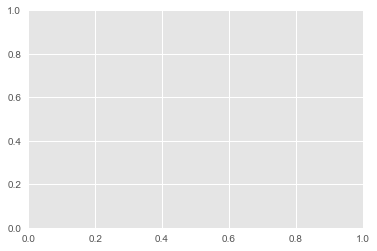

In [12]:
# Define parameters
param_penalty = ['l1', 'l2']
params = {
    'penalty': param_penalty
}

# Grid Search with CV
cv_res, best_subsample = kt.score_grid(
    estimator = LinearSVC(
        random_state = 123,
        dual = False,
        # penalty = 'l2',
        loss = 'squared_hinge',
        C = best_c
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 4: Tune Loss

Computing test scores for loss = hinge...Done!
Computing test scores for loss = squared_hinge...Done!


[ RESULTS ]
   Best Score: 0.8334385327686098
Optimal Value: squared_hinge


ValueError: could not convert string to float: 'hinge'

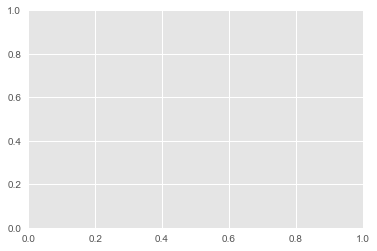

In [14]:
# Define parameters
param_loss = ['hinge', 'squared_hinge']
params = {
    'loss': param_loss
}

# Grid Search with CV
cv_res, best_subsample = kt.score_grid(
    estimator = LinearSVC(
        random_state = 123,
        dual = True,
        penalty = 'l2',
        # loss = 'squared_hinge',
        C = best_c
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 4: Re-tune C

Computing test scores for C = 0.001...Done!
Computing test scores for C = 0.005...Done!
Computing test scores for C = 0.01...Done!
Computing test scores for C = 0.015...Done!
Computing test scores for C = 0.02...Done!
Computing test scores for C = 0.025...Done!
Computing test scores for C = 0.03...Done!
Computing test scores for C = 0.035...Done!
Computing test scores for C = 0.04...Done!
Computing test scores for C = 0.045...Done!
Computing test scores for C = 0.05...Done!


[ RESULTS ]
   Best Score: 0.8305095384864177
Optimal Value: 0.035


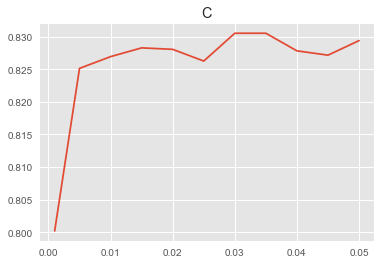

In [20]:
# Define parameters
param_c = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
params = {
    'C': param_c
}

# Grid Search with CV
cv_res, best_c = kt.score_grid(
    estimator = LinearSVC(
        random_state = 123,
        penalty = 'l2',
        loss = 'squared_hinge'
        # C = best_c
    ),  
    params = params,
    all_sets = all_sets,
    n_jobs = 3,
    verbose = True
)